In [1]:
%pip install -U pyobjc-framework-Quartz pyobjc-framework-Vision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import numpy as np
import glob
import Quartz
import Vision
import CoreFoundation
from Cocoa import NSURL
from Foundation import NSDictionary, NSArray
import matplotlib.pyplot as plt

import requests as req

from glob import glob
from tqdm import tqdm
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import bs4

In [8]:
all_papers = req.get("https://ceur-ws.org/Vol-4038/").text
soup = bs4.BeautifulSoup(all_papers, "html.parser")
# get all lis
lis = soup.find_all("li")
papers = []
for li in lis:
    if "paper" not in li.attrs["id"]:
        continue
    title = li.select_one(".CEURTITLE")
    authors = li.select(".CEURAUTHOR")
    authors_combined = ', '.join([a.text for a in authors])
    link = li.select_one("a")["href"]
    papers.append(
        {
            "title": title.text,
            "authors": authors_combined,
            "link": f"https://ceur-ws.org/Vol-4038/{link}",
        }
    )
df_papers = pd.DataFrame(papers)


In [9]:
df_papers.describe()

,title,authors,link
count,392,392,392
unique,392,377,392
top,Overview of BioASQ Tasks 13b and Synergy13 in ...,Poojan Vachharajani,https://ceur-ws.org/Vol-4038/paper_1.pdf
freq,1,7,1


In [10]:
import json
with open("papers.json", "w") as f:
    df_papers.to_json(f, indent=2, orient="records")

In [11]:
df_papers

,title,authors,link
0,Overview of BioASQ Tasks 13b and Synergy13 in ...,"Anastasios Nentidis, Georgios Katsimpras, Anas...",https://ceur-ws.org/Vol-4038/paper_1.pdf
1,Overview of MultiClinSum Task at BioASQ 2025: ...,"Miguel Rodríguez-Ortega, Eduard Rodríguez-Lópe...",https://ceur-ws.org/Vol-4038/paper_2.pdf
2,Overview of the BioASQ BioNNE-L Task on Biomed...,"Andrey Sakhovskiy, Natalia Loukachevitch, Elen...",https://ceur-ws.org/Vol-4038/paper_3.pdf
3,Overview of ElCardioCC Task on Clinical Coding...,"Dimitris Dimitriadis, Vasiliki Patsiou, Eleono...",https://ceur-ws.org/Vol-4038/paper_4.pdf
4,Overview of GutBrainIE@CLEF 2025: Gut-Brain In...,"Marco Martinelli, Gianmaria Silvello, Vanessa ...",https://ceur-ws.org/Vol-4038/paper_5.pdf
...,...,...,...
387,DS@GT at Touché: Large Language Models for Ret...,"Anthony Miyaguchi, Conor Johnston, Aaryan Potdar",https://ceur-ws.org/Vol-4038/paper_387.pdf
388,"Infotec+CentroGEO at Touché: MCIP, CLIP and SB...","Tania Ramirez-delreal, Daniela Moctezuma, Guil...",https://ceur-ws.org/Vol-4038/paper_388.pdf
389,TüNLP at Touché: Finetuning Multilingual Model...,"Aydemir Shamsutdinov, Joaquin Cherta-Rodríguez",https://ceur-ws.org/Vol-4038/paper_389.pdf
390,SINAI at Touché: From Generation to Evaluation...,"María Estrella Vallecillo-Rodríguez, María Ter...",https://ceur-ws.org/Vol-4038/paper_390.pdf


In [12]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
)
tfidf.fit(df_papers["title"].fillna(""))
tfidf.get_feature_names_out()

array(['10', '10 entity', '13b', ..., 'you need', 'zero', 'zero shot'],
      shape=(4246,), dtype=object)

In [13]:
nn = NearestNeighbors(n_neighbors=1, metric="cosine").fit(
    tfidf.transform(
        df_papers["title"].fillna("")
    )
)
result_dist, result_idx = nn.kneighbors(tfidf.transform(["Gut Instincts"]))
df_papers.iloc[result_idx[0]]

,title,authors,link
5,Trusting Gut Instincts: Transformer-Based Extr...,"Lasse Ryge Andersen, Mikkel Hagerup Dolmer, Ma...",https://ceur-ws.org/Vol-4038/paper_6.pdf


In [14]:
def order_points(pts):
    """Rearrange coordinates to order:
    top-left, top-right, bottom-right, bottom-left"""
    rect = np.zeros((4, 2), dtype="float32")
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype("int").tolist()


def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    return order_points(destination_corners)


def scan(img, name=""):
    # Resize image to workable size
    dim_limit = 1920
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    img = img * mask2[:, :, np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    candidates = []
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        area = cv2.contourArea(corners)
        # If our approximated contour has four points.
        if len(corners) == 4:
            candidates.append((corners, area))
    if len(candidates) == 0:
        return orig_img
    candidates.sort(key=lambda x: x[1], reverse=True)
    corners = candidates[0][0]
    print(candidates)
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points(corners)

    destination_corners = find_dest(corners)

    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(
        np.float32(corners), np.float32(destination_corners)
    )
    # Perspective transform using homography.
    final = cv2.warpPerspective(
        orig_img,
        M,
        (destination_corners[2][0], destination_corners[2][1]),
        flags=cv2.INTER_LINEAR,
    )
    return final

In [15]:
imgs = glob("figures/posters/initial/*.png")
# for img in tqdm(imgs):
#     print(img)
#     img_dat=cv2.imread(img)
#     final=scan(img_dat)
#     cv2.imwrite('out/'+img.split('/')[-1], final)
len(imgs)

3

In [16]:
def make_request_handler_img(results):
    """results: list to store results"""
    if not isinstance(results, list):
        raise ValueError("results must be a list")

    def handler(request, error):
        if error:
            print(f"Error! {error}")
        else:
            observations: "list[Vision.VNRecognizedTextObservation]" = request.results()
            for text_observation in observations:
                recognized_text = text_observation.topCandidates_(1)[0]
                corners = {
                    "tl": text_observation.topLeft(),
                    "tr": text_observation.topRight(),
                    "bl": text_observation.bottomLeft(),
                    "br": text_observation.bottomRight(),
                }
                corners = {k: (v.x, v.y) for k, v in corners.items()}
                results.append(
                    [recognized_text.string(), recognized_text.confidence(), corners]
                )

    return handler


def image_to_text(
    img_path, lang="eng"
) -> "list[tuple[str, float, dict[str,tuple[float,float]]]]":
    input_url = NSURL.fileURLWithPath_(img_path)

    input_image = Quartz.CIImage.imageWithContentsOfURL_(input_url)

    vision_options = NSDictionary.dictionaryWithDictionary_({})

    vision_handler = Vision.VNImageRequestHandler.alloc().initWithCIImage_options_(
        input_image, vision_options
    )
    results = []
    handler = make_request_handler_img(results)
    vision_request = Vision.VNRecognizeTextRequest.alloc().initWithCompletionHandler_(
        handler
    )
    # print(vision_request.recognitionLanguages())
    vision_request.setRecognitionLanguages_(
        NSArray.arrayWithArray_(
            [
                lang,
            ]
        )
    )
    # vision_request.setCustomWords_(NSArray.arrayWithArray_(['für',]))
    # print(type(vision_request.recognitionLanguages()))
    # print(vision_request.recognitionLanguages())
    vision_request.setUsesCPUOnly_(False)  # somehow improves accuracy??
    error = vision_handler.performRequests_error_([vision_request], None)

    return results

In [17]:
def find_dest_doc(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br - bl) ** 2).sum())
    widthB = np.sqrt(((tr - tl) ** 2).sum())
    maxWidth = max(int(widthA), int(widthB))

    # Finding the maximum height.
    heightA = np.sqrt(((tr - br) ** 2).sum())
    heightB = np.sqrt(((tl - bl) ** 2).sum())
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [
        [0, 0],
        [maxWidth, 0],
        [0, maxHeight],
        [maxWidth, maxHeight],
    ]

    return destination_corners


def make_request_handler_doc(results):
    """results: list to store results"""
    if not isinstance(results, list):
        raise ValueError("results must be a list")

    def handler(request, error):
        if error:
            print(f"Error! {error}")
        else:
            observations = request.results()
            for obs in observations:
                # print(obs)
                # print(obs.bottomLeft())
                # print(obs.bottomRight())
                bbox = obs.boundingBox()
                corners = {
                    "tl": obs.topLeft(),
                    "tr": obs.topRight(),
                    "bl": obs.bottomLeft(),
                    "br": obs.bottomRight(),
                }
                corners = {k: (v.x, v.y) for k, v in corners.items()}
                results.append(
                    {
                        "bbox": corners,
                        "bbox_obj": bbox,
                        "conf": obs.confidence(),
                    }
                )

    return handler


def image_doc_handler(img_path: str) -> str:
    input_url = NSURL.fileURLWithPath_(img_path)

    input_image = Quartz.CIImage.imageWithContentsOfURL_(input_url)

    vision_options = NSDictionary.dictionaryWithDictionary_({})

    vision_handler = Vision.VNImageRequestHandler.alloc().initWithCIImage_options_(
        input_image, vision_options
    )
    results = []
    handler = make_request_handler_doc(results)
    vision_request = (
        Vision.VNDetectDocumentSegmentationRequest.alloc().initWithCompletionHandler_(
            handler
        )
    )
    # print(vision_request.recognitionLanguages())
    # vision_request.setRecognitionLanguages_(NSArray.arrayWithArray_([lang,]))
    # vision_request.setCustomWords_(NSArray.arrayWithArray_(['für',]))
    # print(type(vision_request.recognitionLanguages()))
    # print(vision_request.recognitionLanguages())
    # vision_request.setUsesCPUOnly_(False) # somehow improves accuracy??
    error = vision_handler.performRequests_error_([vision_request], None)

    return results


res = image_doc_handler(imgs[0])
res

[{'bbox': {'tl': (0.0763888880610466, 0.83203125),
   'tr': (0.6736111044883728, 0.8984375),
   'bl': (0.1319444477558136, 0.21875),
   'br': (0.6319444179534912, 0.0625)},
  'bbox_obj': <CoreFoundation.CGRect origin=<CoreFoundation.CGPoint x=0.0763888880610466 y=0.0625> size=<CoreFoundation.CGSize width=0.5972222164273262 height=0.8359375>>,
  'conf': 0.9081398248672485}]

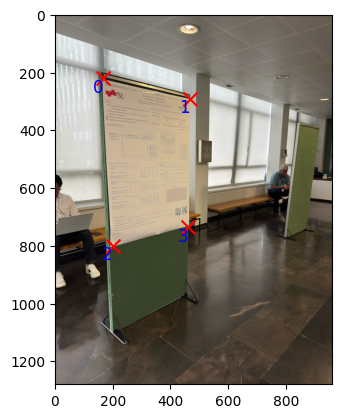

In [18]:
img = imgs[1]
res = image_doc_handler(img)
img_dat = cv2.imread(img)
src=np.array([
    res[0]["bbox"]["tl"],
    res[0]["bbox"]["tr"],
    res[0]["bbox"]["bl"],
    res[0]["bbox"]["br"],
])
# src = np.array([list(p) for p in res[0]["bbox"].values()])
dst = np.array(
    [
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1],
    ]
)
shape = np.flip(img_dat.shape[:2])
src = src * shape
dst_scaled = find_dest_doc(src)
src_flipped_y = np.copy(src)
src_flipped_y[:, 1] = shape[1] - src[:, 1]
plt.imshow(cv2.cvtColor(img_dat, cv2.COLOR_BGR2RGB))
plt.scatter(src_flipped_y[:, 0], src_flipped_y[:, 1], marker="x", color="red", s=100)
for i, (x, y) in enumerate(src_flipped_y):
    plt.text(x, y, str(i), color="blue", fontsize=12, ha="right", va="top")

In [19]:
dst_scaled

[[0, 0], [308, 0], [0, 592], [308, 592]]

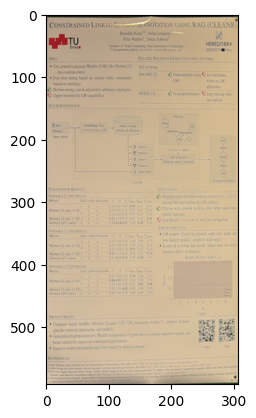

In [20]:
dst_mtx= np.array(dst_scaled).astype("float32")
src_mtx = np.array(src_flipped_y).astype("float32")
M = cv2.getPerspectiveTransform(src_mtx,dst_mtx)
dst_size=tuple(dst_mtx.max(axis=0).astype('int').tolist())

warped = cv2.warpPerspective(img_dat, M, dst_size, flags=cv2.INTER_LINEAR)
# warped_flipped=cv2.
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

In [21]:
dst_size

(308, 592)

In [22]:
def extract_poster_img(img: str):
    res = image_doc_handler(img)
    img_dat = cv2.imread(img)
    src = np.array([list(p) for p in res[0]["bbox"].values()])
    shape = np.flip(img_dat.shape[:2])
    src = src * shape
    dst_scaled = find_dest_doc(src)
    src_flipped_y = np.copy(src)
    src_flipped_y[:, 1] = shape[1] - src[:, 1]

    dst_mtx= np.array(dst_scaled).astype("float32")
    src_mtx = np.array(src_flipped_y).astype("float32")
    M = cv2.getPerspectiveTransform(src_mtx,dst_mtx)
    dst_size=tuple(dst_mtx.max(axis=0).astype('int').tolist())

    warped = cv2.warpPerspective(img_dat, M, dst_size, flags=cv2.INTER_LINEAR)

    return warped


for img in tqdm(imgs):
    img_path = Path(img)
    warped = extract_poster_img(img)
    target_path = img_path.parent.parent / "warped" / img_path.parts[-1]

    cv2.imwrite(str(target_path), warped)

100%|██████████| 3/3 [00:00<00:00,  9.14it/s]


In [23]:
def authors_text(texts):
    results = texts
    for textbox in results:
        commas = (
            textbox[0].count(",")
            + textbox[0].count("and")
            + textbox[0].count("&")
            + textbox[0].count(".")
        )

        textbox.append(commas)
    results.sort(key=lambda x: x[-1], reverse=True)
    return results[0][0] if len(results) else ""


def biggest_text(texts):
    results = texts
    for textbox in results:
        dims = textbox[2]
        poss = np.array([dims["tl"], dims["tr"], dims["br"], dims["bl"]]).astype(
            np.float32
        )
        area = cv2.contourArea(poss)
        textbox.append(area)
    results.sort(key=lambda x: x[-1], reverse=True)
    return results[0][0] if len(results) else ""

In [24]:
outs = glob("figures/posters/warped/*.png")
for img in tqdm(outs):
    img_dat = cv2.imread(img)
    # downscale image
    dim_limit = 1080
    max_dim = max(img_dat.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img_dat = cv2.resize(img_dat, None, fx=resize_scale, fy=resize_scale)
    cv2.imwrite("figures/posters/reduced/" + img.split("/")[-1], img_dat)

100%|██████████| 3/3 [00:00<00:00, 31.92it/s]


In [25]:
data = []

for img in tqdm(outs):
    texts = image_to_text(img, "eng")
    title = biggest_text(texts)
    authors = authors_text(texts)

    # print(title, authors)
    data.append(
        {
            "title": title,
            "authors": authors,
            "texts": texts,
            "img": img,
            "img_reduced": Path(img).parent.parent / "reduced" / Path(img).parts[-1],
        }
    )

100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


In [26]:
data_df=pd.DataFrame(data)
data_df

,title,authors,texts,img,img_reduced
0,Trusting Gut Instincts: Transformer-Based Extr...,"Lasse Ryge Andersen, Mikkel Hagerup Dolmer, Ma...","[[Lasse Ryge Andersen, Mikkel Hagerup Dolmer, ...",figures/posters/warped/IMG_4274.png,figures/posters/reduced/IMG_4274.png
1,CONSTRAINED LINKED DETENT CONNOTATION USING RA...,Upper bounded by I.M capablises.,"[[Upper bounded by I.M capablises., 0.5, {'tl'...",figures/posters/warped/IMG_4289.png,figures/posters/reduced/IMG_4289.png
2,Fine-Tuning a Vision-Language Model for Medica...,"# Standardied concept, extraction.","[[# Standardied concept, extraction., 1.0, {'t...",figures/posters/warped/IMG_4324.png,figures/posters/reduced/IMG_4324.png


In [27]:
data_df["url"] = ""
data_df["abstract"] = ""

In [28]:
df_papers

,title,authors,link
0,Overview of BioASQ Tasks 13b and Synergy13 in ...,"Anastasios Nentidis, Georgios Katsimpras, Anas...",https://ceur-ws.org/Vol-4038/paper_1.pdf
1,Overview of MultiClinSum Task at BioASQ 2025: ...,"Miguel Rodríguez-Ortega, Eduard Rodríguez-Lópe...",https://ceur-ws.org/Vol-4038/paper_2.pdf
2,Overview of the BioASQ BioNNE-L Task on Biomed...,"Andrey Sakhovskiy, Natalia Loukachevitch, Elen...",https://ceur-ws.org/Vol-4038/paper_3.pdf
3,Overview of ElCardioCC Task on Clinical Coding...,"Dimitris Dimitriadis, Vasiliki Patsiou, Eleono...",https://ceur-ws.org/Vol-4038/paper_4.pdf
4,Overview of GutBrainIE@CLEF 2025: Gut-Brain In...,"Marco Martinelli, Gianmaria Silvello, Vanessa ...",https://ceur-ws.org/Vol-4038/paper_5.pdf
...,...,...,...
387,DS@GT at Touché: Large Language Models for Ret...,"Anthony Miyaguchi, Conor Johnston, Aaryan Potdar",https://ceur-ws.org/Vol-4038/paper_387.pdf
388,"Infotec+CentroGEO at Touché: MCIP, CLIP and SB...","Tania Ramirez-delreal, Daniela Moctezuma, Guil...",https://ceur-ws.org/Vol-4038/paper_388.pdf
389,TüNLP at Touché: Finetuning Multilingual Model...,"Aydemir Shamsutdinov, Joaquin Cherta-Rodríguez",https://ceur-ws.org/Vol-4038/paper_389.pdf
390,SINAI at Touché: From Generation to Evaluation...,"María Estrella Vallecillo-Rodríguez, María Ter...",https://ceur-ws.org/Vol-4038/paper_390.pdf


In [29]:
for i, row in tqdm(data_df.iterrows(), total=len(data_df)):
    title = row["title"]
    authors = row["authors"]
    k_nn=1
    
    result_dist, result_idx = nn.kneighbors(
        tfidf.transform([title + " " + authors])
    )
    result=df_papers.iloc[result_idx[0]]
    
    data_df.loc[i, "url"] = result["link"].values[0]
    data_df.loc[i, "title"] = result["title"].values[0]
    # data_df.loc[i, "abstract"] = result["abstract"].values[0]

100%|██████████| 3/3 [00:00<00:00, 508.81it/s]


In [30]:
data_df

,title,authors,texts,img,img_reduced,url,abstract
0,Trusting Gut Instincts: Transformer-Based Extr...,"Lasse Ryge Andersen, Mikkel Hagerup Dolmer, Ma...","[[Lasse Ryge Andersen, Mikkel Hagerup Dolmer, ...",figures/posters/warped/IMG_4274.png,figures/posters/reduced/IMG_4274.png,https://ceur-ws.org/Vol-4038/paper_6.pdf,
1,Constrained Linked Entity ANnotation using RAG...,Upper bounded by I.M capablises.,"[[Upper bounded by I.M capablises., 0.5, {'tl'...",figures/posters/warped/IMG_4289.png,figures/posters/reduced/IMG_4289.png,https://ceur-ws.org/Vol-4038/paper_23.pdf,
2,UMUTeam at ImageCLEF 2025: Fine-Tuning a Visio...,"# Standardied concept, extraction.","[[# Standardied concept, extraction., 1.0, {'t...",figures/posters/warped/IMG_4324.png,figures/posters/reduced/IMG_4324.png,https://ceur-ws.org/Vol-4038/paper_200.pdf,


In [31]:
%pip install -U pylatex

Note: you may need to restart the kernel to use updated packages.


In [32]:
from pylatex.utils import escape_latex

In [34]:
with open("./posters.tex", "w") as f:
    f.write("| **Poster** | **Title** | **Information** | \n")
    separator="| -- | -- | -- | \n"
    f.write(separator)
    lines=[
        f'| ![poster](out_reduced/{poster["img"].split("/")[-1]}) | {poster["title"].replace("|", " ")} | *{escape_latex(poster["authors"].replace("|", " "))}*, [{escape_latex(poster["title"].replace("≥", " "))}]({escape_latex(poster["url"])}) | \n' for i,poster in data_df.iterrows()
    ]
    f.write("".join(lines))
    